In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import math
import os
import time
import warnings
from typing import Optional          
warnings.filterwarnings('ignore')


In [8]:
# ──────────────────────── trading-bot class ────────────────────────
class XAUUSDCentScalpingBot:
    def __init__(
        self,
        *,
        initial_capital=100_000,           # 1000 USD represented as 100 000 ¢
        risk_percent=1.0,                  # Risk % per trade
        take_profit_points=50,             # 50 points (5 pips)
        stop_loss_points=35,               # 35 points (3.5 pips)
        fast_ma_period=8,
        slow_ma_period=21,
        stoch_k_period=8,
        stoch_d_period=3,
        stoch_slowing=3,
        stoch_upper_level=75,
        stoch_lower_level=25,
        avg_spread_points=25,
        use_fixed_lot_size=False,
        fixed_lot_size=0.01,
        max_lot_size=0.05,
        min_lot_size=0.01,
        trailing_stop=False,
        trailing_distance=20,
        rsi_period=14,
        rsi_overbought=70,
        rsi_oversold=30,
        use_rsi_filter=True,
        use_atr_filter=True,
        atr_period=14,
        atr_multiplier=1.5,
        trading_hours=None,                # dict {'start': int, 'end': int}
        max_daily_loss=-5.0,               # % of account
        recovery_factor=0.5,               # size reduction after losses
        consecutive_losses_limit=3
    ):
        # Session hours (defaults to 08-16)
        self.trading_hours = trading_hours or {"start": 8, "end": 16}

        # ── account │ risk ──────────────────────────────────────────
        self.initial_capital = initial_capital      # cents
        self.current_balance = initial_capital      # cents
        self.risk_percent = risk_percent
        self.max_daily_loss = max_daily_loss
        self.use_fixed_lot_size = use_fixed_lot_size
        self.fixed_lot_size = fixed_lot_size
        self.min_lot_size = min_lot_size
        self.max_lot_size = max_lot_size
        self.recovery_factor = recovery_factor
        self.consecutive_losses_limit = consecutive_losses_limit

        # ── trade params ────────────────────────────────────────────
        self.take_profit_points = take_profit_points
        self.stop_loss_points = stop_loss_points
        self.avg_spread_points = avg_spread_points
        self.trailing_stop = trailing_stop
        self.trailing_distance = trailing_distance

        # ── strategy params ─────────────────────────────────────────
        self.fast_ma_period = fast_ma_period
        self.slow_ma_period = slow_ma_period
        self.stoch_k_period = stoch_k_period
        self.stoch_d_period = stoch_d_period
        self.stoch_slowing = stoch_slowing
        self.stoch_upper_level = stoch_upper_level
        self.stoch_lower_level = stoch_lower_level
        self.rsi_period = rsi_period
        self.rsi_overbought = rsi_overbought
        self.rsi_oversold = rsi_oversold
        self.use_rsi_filter = use_rsi_filter
        self.use_atr_filter = use_atr_filter
        self.atr_period = atr_period
        self.atr_multiplier = atr_multiplier

        # ── runtime state ───────────────────────────────────────────
        self.position = None            # 'buy', 'sell', or None
        self.entry_price = 0
        self.stop_loss_price = 0
        self.take_profit_price = 0
        self.trailing_stop_price = 0
        self.position_size = 0
        self.consecutive_losses = 0
        self.daily_profit_loss = 0
        self.last_trade_date = None

        # ── performance tracking ────────────────────────────────────
        self.trades = []
        self.equity_curve = []
        self.daily_results = {}
        self.trade_details = {}

        # ── debug counters ──────────────────────────────────────────
        self.signal_counts = {
            "ma_bullish": 0,
            "ma_bearish": 0,
            "stoch_oversold": 0,
            "stoch_overbought": 0,
            "k_above_d": 0,
            "k_below_d": 0,
            "buy_signals": 0,
            "sell_signals": 0,
            "rsi_buy_confirmed": 0,
            "rsi_sell_confirmed": 0,
            "atr_filtered_out": 0,
        }

    # ─────────────────────── data helpers ──────────────────────────
 

    def load_data(self, csv_file: str) -> Optional[pd.DataFrame]:
        """
        Load & prepare CSV (semicolon-delimited, cent-account price format).

        Parameters
        ----------
        csv_file : str
            Full path (or relative path) to the CSV file.

        Returns
        -------
        Optional[pandas.DataFrame]
            A prepared DataFrame, or None if an error occurs.
        """
        try:
            # read the file that was passed in, not a hard-coded path
            df = pd.read_csv(csv_file, sep=";", skiprows=1)

            # clean column names
            df.columns = [c.replace('"', '') for c in df.columns]

            # rename to standard names if present
            mapping = {
                "Timestamp": "datetime",
                "Open": "open",
                "High": "high",
                "Low": "low",
                "Close": "close",
                "Volume": "volume",
            }
            df = df.rename(columns={k: v for k, v in mapping.items() if k in df.columns})

            # strip stray quotes from string columns
            for col in df.select_dtypes(include="object"):
                df[col] = df[col].str.replace('"', '')

            # parse datetime and set index
            df["datetime"] = pd.to_datetime(df["datetime"])
            df.set_index("datetime", inplace=True)

            # force numeric types
            numeric_cols = ["open", "high", "low", "close", "volume"]
            for col in numeric_cols:
                if col in df.columns:
                    df[col] = pd.to_numeric(df[col], errors="coerce")

            # synthesize bid/ask and spread
            spread_val = self.avg_spread_points * 0.001
            df["ask"] = df["close"] + spread_val / 2
            df["bid"] = df["close"] - spread_val / 2
            df["spread_points"] = (df["ask"] - df["bid"]) * 1000

            print(f"Data loaded: {len(df)} rows ({df.index.min()} → {df.index.max()})")
            return df

        except Exception as exc:
            print(f"Error loading data: {exc}")
            return None

    def resample_data(self, df: pd.DataFrame, timeframe="5T") -> pd.DataFrame:
        """
        Resample OHLCV to a new timeframe (e.g. '5T', '1H', '4H', 'D').
        """
        print(f"Resampling to {timeframe}")
        res = (
            df.resample(timeframe)
            .agg(
                {
                    "open": "first",
                    "high": "max",
                    "low": "min",
                    "close": "last",
                    "volume": "sum",
                }
            )
            .dropna()
        )

        spread_val = self.avg_spread_points * 0.001
        res["ask"] = res["close"] + spread_val / 2
        res["bid"] = res["close"] - spread_val / 2
        return res

    def prepare_data(self, df: pd.DataFrame) -> pd.DataFrame:
        """Compute indicators used by the strategy."""
        # Moving averages
        df["fast_ma"] = df["close"].rolling(self.fast_ma_period).mean()
        df["slow_ma"] = df["close"].rolling(self.slow_ma_period).mean()

        # Stochastic
        df["lowest_low"] = df["low"].rolling(self.stoch_k_period).min()
        df["highest_high"] = df["high"].rolling(self.stoch_k_period).max()
        df["stoch_k"] = (
            100
            * (df["close"] - df["lowest_low"])
            / (df["highest_high"] - df["lowest_low"])
        )

        if self.stoch_slowing > 1:
            df["stoch_k"] = df["stoch_k"].rolling(self.stoch_slowing).mean()
        df["stoch_d"] = df["stoch_k"].rolling(self.stoch_d_period).mean()

        # RSI
        if self.use_rsi_filter:
            delta = df["close"].diff()
            gain = delta.clip(lower=0)
            loss = -delta.clip(upper=0)
            avg_gain = gain.rolling(self.rsi_period).mean()
            avg_loss = loss.rolling(self.rsi_period).mean()
            rs = avg_gain / avg_loss
            df["rsi"] = 100 - 100 / (1 + rs)

        # ATR
        if self.use_atr_filter:
            tr = pd.concat(
                [
                    df["high"] - df["low"],
                    (df["high"] - df["close"].shift()).abs(),
                    (df["low"] - df["close"].shift()).abs(),
                ],
                axis=1,
            ).max(axis=1)
            df["atr"] = tr.rolling(self.atr_period).mean()
            df["atr_threshold"] = df["atr"] * self.atr_multiplier

        df.dropna(inplace=True)
        return df

    # ────────────────────── utility helpers ────────────────────────
    @staticmethod
    def _trade_date(ts):
        return ts.date() if isinstance(ts, pd.Timestamp) else ts.date()

    def reset_daily_stats(self, current_date):
        if self.last_trade_date is None or current_date != self.last_trade_date:
            if self.last_trade_date is not None:
                self.daily_results[self.last_trade_date] = self.daily_profit_loss
            self.daily_profit_loss = 0
            print(f"── new trading day {current_date} ──")
        self.last_trade_date = current_date

    def calculate_lot_size(self, stop_loss_points):
        if self.use_fixed_lot_size:
            return self.fixed_lot_size

        usd_balance = self.current_balance / 100
        risk_usd = usd_balance * self.risk_percent / 100

        if self.consecutive_losses >= self.consecutive_losses_limit:
            risk_usd *= self.recovery_factor

        value_per_point_per_01lot = 1.0  # $/point per 0.01 lot
        lots = risk_usd / (stop_loss_points * value_per_point_per_01lot / 100)
        lots = math.floor(lots * 100) / 100
        lots = max(self.min_lot_size, min(lots, self.max_lot_size))

        if self.current_balance < 5_000:  # < $50
            lots = self.min_lot_size
        return lots

    # ────────────────────── signal generation ──────────────────────
    def check_entry_signals(self, row):
        """
        Check if there's an entry signal based on current conditions
        """
        hour = row.name.hour if isinstance(row.name, datetime) else row.name.hour
        
        # Check if we're in trading hours
        if hour < self.trading_hours['start'] or hour >= self.trading_hours['end']:
            return None
        
        # Get current date for daily tracking
        current_date = self.get_trade_date(row.name)
        self.reset_daily_stats(current_date)
        
        # Check if we hit the daily loss limit
        if self.daily_profit_loss <= (self.initial_capital * self.max_daily_loss / 100):
            print(f"Daily loss limit reached: {self.daily_profit_loss} cents. No more trading today.")
            return None
                
        # Track indicator conditions for debugging
        ma_bullish = row['fast_ma'] > row['slow_ma']
        ma_bearish = row['fast_ma'] < row['slow_ma']
        stoch_oversold = row['stoch_k'] < self.stoch_lower_level
        stoch_overbought = row['stoch_k'] > self.stoch_upper_level
        k_above_d = row['stoch_k'] > row['stoch_d']
        k_below_d = row['stoch_d'] > row['stoch_k']
        
        # Update signal counters
        if ma_bullish: self.signal_counts['ma_bullish'] += 1
        if ma_bearish: self.signal_counts['ma_bearish'] += 1
        if stoch_oversold: self.signal_counts['stoch_oversold'] += 1
        if stoch_overbought: self.signal_counts['stoch_overbought'] += 1
        if k_above_d: self.signal_counts['k_above_d'] += 1
        if k_below_d: self.signal_counts['k_below_d'] += 1
        
        # Check for high volatility if using ATR filter
        if self.use_atr_filter:
            current_volatility = abs(row['high'] - row['low'])  # Use abs() function instead of .abs() method
            if current_volatility > row['atr_threshold']:
                self.signal_counts['atr_filtered_out'] += 1
                return None
        
        # BUY signal - MA bullish + Stochastic oversold
        if ma_bullish and stoch_oversold:
            # Additional RSI filter for buy signals if enabled
            if self.use_rsi_filter:
                if row['rsi'] > self.rsi_oversold:  # Confirming bullish momentum with RSI
                    self.signal_counts['rsi_buy_confirmed'] += 1
                else:
                    return None
                    
            print(f"BUY SIGNAL at {row.name}: Fast MA: {row['fast_ma']:.2f}, Slow MA: {row['slow_ma']:.2f}, K: {row['stoch_k']:.2f}, D: {row['stoch_d']:.2f}")
            self.signal_counts['buy_signals'] += 1
            return 'buy'
        
        # SELL signal - MA bearish + Stochastic overbought
        elif ma_bearish and stoch_overbought:
            # Additional RSI filter for sell signals if enabled
            if self.use_rsi_filter:
                if row['rsi'] < self.rsi_overbought:  # Confirming bearish momentum with RSI
                    self.signal_counts['rsi_sell_confirmed'] += 1
                else:
                    return None
                    
            print(f"SELL SIGNAL at {row.name}: Fast MA: {row['fast_ma']:.2f}, Slow MA: {row['slow_ma']:.2f}, K: {row['stoch_k']:.2f}, D: {row['stoch_d']:.2f}")
            self.signal_counts['sell_signals'] += 1
            return 'sell'
        
        return None

    # ───────────────────────── trade logic ─────────────────────────
    def open_position(self, signal, row):
        self.position_size = self.calculate_lot_size(self.stop_loss_points)

        if signal == "buy":
            self.entry_price = row["ask"]
            self.stop_loss_price = self.entry_price - self.stop_loss_points * 0.001
            self.take_profit_price = self.entry_price + self.take_profit_points * 0.001
            if self.trailing_stop:
                self.trailing_stop_price = self.stop_loss_price
        else:  # sell
            self.entry_price = row["bid"]
            self.stop_loss_price = self.entry_price + self.stop_loss_points * 0.001
            self.take_profit_price = self.entry_price - self.take_profit_points * 0.001
            if self.trailing_stop:
                self.trailing_stop_price = self.stop_loss_price

        self.position = signal
        trade = {
            "entry_time": row.name,
            "position": signal,
            "entry_price": self.entry_price,
            "stop_loss": self.stop_loss_price,
            "take_profit": self.take_profit_price,
            "lot_size": self.position_size,
        }
        print(
            f"Open {signal} @ {self.entry_price:.3f}  SL={self.stop_loss_price:.3f} "
            f"TP={self.take_profit_price:.3f}  lot={self.position_size:.2f}"
        )
        return trade

    def update_trailing_stop(self, row):
        if not self.trailing_stop:
            return False

        if self.position == "buy":
            new_stop = row["bid"] - self.trailing_distance * 0.001
            if new_stop > self.trailing_stop_price:
                self.trailing_stop_price = new_stop
                if self.trailing_stop_price > self.stop_loss_price:
                    self.stop_loss_price = self.trailing_stop_price
                    return True
        else:  # sell
            new_stop = row["ask"] + self.trailing_distance * 0.001
            if new_stop < self.trailing_stop_price:
                self.trailing_stop_price = new_stop
                if self.trailing_stop_price < self.stop_loss_price:
                    self.stop_loss_price = self.trailing_stop_price
                    return True
        return False

    def check_exit_conditions(self, row):
        if self.position is None:
            return False, 0, ""

        self.update_trailing_stop(row)

        c_bid = row["bid"]
        c_ask = row["ask"]

        if self.position == "buy":
            # stop-loss
            if c_bid <= self.stop_loss_price:
                points = (c_bid - self.entry_price) * 1000
                profit = points * self.position_size * 100
                return True, profit, "stop loss"
            # take-profit
            if c_bid >= self.take_profit_price:
                points = (c_bid - self.entry_price) * 1000
                profit = points * self.position_size * 100
                return True, profit, "take profit"

        else:  # sell
            if c_ask >= self.stop_loss_price:
                points = (self.entry_price - c_ask) * 1000
                profit = points * self.position_size * 100
                return True, profit, "stop loss"
            if c_ask <= self.take_profit_price:
                points = (self.entry_price - c_ask) * 1000
                profit = points * self.position_size * 100
                return True, profit, "take profit"

        return False, 0, ""

    def close_position(self, row, profit, reason):
        exit_price = row["bid"] if self.position == "buy" else row["ask"]

        self.current_balance += profit
        self.daily_profit_loss += profit
        self.consecutive_losses = self.consecutive_losses + 1 if profit <= 0 else 0

        result = {
            "exit_time": row.name,
            "exit_price": exit_price,
            "profit": profit,
            "balance": self.current_balance,
            "exit_reason": reason,
        }

        print(
            f"Close {self.position} @ {exit_price:.3f}  "
            f"p&l={profit/100:.2f}$  balance={self.current_balance/100:.2f}$"
        )

        # reset
        self.position = None
        self.entry_price = self.stop_loss_price = self.take_profit_price = 0
        self.trailing_stop_price = 0
        return result

    # ───────────────────────── back-test ───────────────────────────
    def backtest(self, csv_file, *, use_timeframe=None):
        data = self.load_data(csv_file)
        if data is None:
            return None

        if use_timeframe:
            data = self.resample_data(data, use_timeframe)

        df = self.prepare_data(data.copy())

        self.trades.clear()
        self.equity_curve = [self.initial_capital]
        current_trade = None

        for _, row in df.iterrows():
            self.equity_curve.append(self.current_balance)

            if self.position is None:
                sig = self.check_entry_signals(row)
                if sig:
                    current_trade = self.open_position(sig, row)
                    self.trade_details[row.name] = {
                        "type": sig,
                        "entry_price": self.entry_price,
                        "stop_loss": self.stop_loss_price,
                        "take_profit": self.take_profit_price,
                    }
            else:
                exit_now, profit, reason = self.check_exit_conditions(row)
                if exit_now:
                    trade_res = self.close_position(row, profit, reason)
                    current_trade.update(trade_res)
                    self.trades.append(current_trade)
                    current_trade = None

        # force close at the end
        if self.position is not None:
            last_row = df.iloc[-1]
            _, profit, _ = self.check_exit_conditions(last_row)
            trade_res = self.close_position(last_row, profit, "end of test")
            current_trade.update(trade_res)
            self.trades.append(current_trade)

        return self.calculate_performance()

    # ────────────────────────── metrics ────────────────────────────
    def calculate_performance(self):
        if not self.trades:
            return {
                "total_trades": 0,
                "winning_trades": 0,
                "losing_trades": 0,
                "win_rate": 0,
                "profit_factor": 0,
                "total_profit_cents": 0,
                "total_profit_usd": 0,
                "max_drawdown_percent": 0,
                "sharpe_ratio": 0,
                "avg_win_cents": 0,
                "avg_loss_cents": 0,
                "largest_win_cents": 0,
                "largest_loss_cents": 0,
                "avg_trade_duration": 0,
            }

        tot = len(self.trades)
        wins = sum(t["profit"] > 0 for t in self.trades)
        losses = tot - wins
        win_rate = wins / tot * 100

        gross_profit = sum(t["profit"] for t in self.trades if t["profit"] > 0)
        gross_loss = abs(sum(t["profit"] for t in self.trades if t["profit"] <= 0))
        profit_factor = gross_profit / gross_loss if gross_loss else float("inf")
        total_profit = gross_profit - gross_loss
        total_profit_usd = total_profit / 100

        avg_win = gross_profit / wins if wins else 0
        avg_loss = gross_loss / losses if losses else 0
        largest_win = max((t["profit"] for t in self.trades if t["profit"] > 0), default=0)
        largest_loss = min(
            (t["profit"] for t in self.trades if t["profit"] <= 0), default=0
        )

        durations = [
            (t["exit_time"] - t["entry_time"]).total_seconds() / 60
            for t in self.trades
        ]
        avg_dur = sum(durations) / len(durations) if durations else 0

        peak = self.initial_capital
        drawdowns = []
        for bal in self.equity_curve:
            if bal > peak:
                peak = bal
            drawdowns.append((peak - bal) / peak * 100 if peak else 0)
        max_dd = max(drawdowns)

        if len(self.equity_curve) > 1:
            rets = [
                self.equity_curve[i] / self.equity_curve[i - 1] - 1
                for i in range(1, len(self.equity_curve))
            ]
            sharpe = (np.mean(rets) / np.std(rets)) * np.sqrt(252) if np.std(rets) else 0
        else:
            sharpe = 0

        return {
            "total_trades": tot,
            "winning_trades": wins,
            "losing_trades": losses,
            "win_rate": win_rate,
            "profit_factor": profit_factor,
            "total_profit_cents": total_profit,
            "total_profit_usd": total_profit_usd,
            "total_return_percent": total_profit / self.initial_capital * 100,
            "max_drawdown_percent": max_dd,
            "sharpe_ratio": sharpe,
            "avg_win_cents": avg_win,
            "avg_loss_cents": avg_loss,
            "largest_win_cents": largest_win,
            "largest_loss_cents": largest_loss,
            "avg_trade_duration": avg_dur,
            "daily_results": self.daily_results,
            "signal_counts": self.signal_counts,
        }

    # ────────────────────────── plotting ───────────────────────────
    def plot_results(self):
        if not self.trades or len(self.equity_curve) <= 1:
            print("Not enough data to plot.")
            return

        fig, (ax1, ax2, ax3) = plt.subplots(
            3, 1, figsize=(12, 15), gridspec_kw={"height_ratios": [3, 1, 1]}
        )

        # equity
        ax1.plot(self.equity_curve)
        ax1.set_title("Equity Curve (¢)")
        ax1.set_ylabel("Balance (¢)")
        ax1.grid(True)

        # trade outcomes
        profits = [t["profit"] for t in self.trades]
        colors = ["green" if p > 0 else "red" for p in profits]
        ax2.bar(range(1, len(profits) + 1), profits, color=colors)
        ax2.set_title("Trade Outcomes (¢)")
        ax2.set_xlabel("Trade #")
        ax2.grid(True)

        # durations
        durs = [
            (t["exit_time"] - t["entry_time"]).total_seconds() / 60 for t in self.trades
        ]
        ax3.bar(range(1, len(durs) + 1), durs)
        ax3.set_title("Trade Durations (min)")
        ax3.set_xlabel("Trade #")
        ax3.grid(True)

        plt.tight_layout()
        plt.show()

        # monthly performance
        if self.daily_results:
            monthly = {}
            for date, profit in self.daily_results.items():
                key = date.strftime("%Y-%m")
                monthly[key] = monthly.get(key, 0) + profit

            fig, ax = plt.subplots(figsize=(12, 6))
            months, perf = zip(*sorted(monthly.items()))
            colors = ["green" if p > 0 else "red" for p in perf]
            ax.bar(months, perf, color=colors)
            ax.set_title("Monthly Performance (¢)")
            ax.set_ylabel("Profit/Loss (¢)")
            ax.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

        # summary
        perf = self.calculate_performance()
        print("\n── Performance Summary ──")
        for k, v in perf.items():
            if k.endswith("_usd"):
                print(f"{k}: ${v:.2f}")
            elif k.endswith("_percent") or k == "win_rate":
                print(f"{k}: {v:.2f}%")
            else:
                print(f"{k}: {v}")

    # ───────────────────────── reporting ───────────────────────────
    def generate_trade_report(self, output_file=None):
        if not self.trades:
            print("No trades to report.")
            return

        perf = self.calculate_performance()
        report = "XAUUSD Cent-Account Scalping Bot — Trade Report\n" + "=" * 80 + "\n\n"
        report += "Performance Summary\n" + "-" * 50 + "\n"
        for k, v in perf.items():
            if k.endswith("_usd"):
                report += f"{k:25s}: ${v:.2f}\n"
            elif k.endswith("_percent") or k == "win_rate":
                report += f"{k:25s}: {v:.2f}%\n"
            else:
                report += f"{k:25s}: {v}\n"
        report += "\n"

        if self.daily_results:
            report += "Daily Performance\n" + "-" * 50 + "\n"
            for d, p in sorted(self.daily_results.items()):
                report += f"{d}: {p/100:.2f}$\n"
            report += "\n"

        report += (
            "Trade Details\n"
            + "-" * 50
            + "\n"
            + f"{'#':<4}{'Type':<6}{'Entry':<20}{'Exit':<20}{'Dur(min)':<10}{'P/L($)':<10}{'Reason':<15}\n"
            + "-" * 100
            + "\n"
        )

        for i, t in enumerate(self.trades, 1):
            dur = (t["exit_time"] - t["entry_time"]).total_seconds() / 60
            report += (
                f"{i:<4}{t['position']:<6}{t['entry_time']:%F %T} "
                f"{t['exit_time']:%F %T} {dur:<10.2f}"
                f"{t['profit']/100:<10.2f}{t.get('exit_reason', ''):<15}\n"
            )

        if output_file:
            with open(output_file, "w") as f:
                f.write(report)
            print(f"Report saved to {output_file}")
        else:
            print(report)


    def get_trade_date(self, timestamp):
        """
        Extract trade date for daily tracking
        """
        if isinstance(timestamp, pd.Timestamp):
            return timestamp.date()
        return timestamp.date() if hasattr(timestamp, 'date') else None
    # ─────────────────────── optimisation ──────────────────────────
    def optimize_parameters(
        self,
        csv_file,
        param_ranges,
        *,
        use_timeframe=None,
        num_combinations=10,
    ):
        import itertools
        import random
        from tqdm import tqdm

        combos = list(itertools.product(*param_ranges.values()))
        if len(combos) > num_combinations:
            combos = random.sample(combos, num_combinations)

        results = []
        for combo in tqdm(combos, desc="Optimising"):
            params = dict(zip(param_ranges.keys(), combo))
            bot = XAUUSDCentScalpingBot(initial_capital=self.initial_capital, **params)
            perf = bot.backtest(csv_file, use_timeframe=use_timeframe)
            if perf:
                results.append(
                    {
                        "parameters": params,
                        "profit_factor": perf["profit_factor"],
                        "win_rate": perf["win_rate"],
                        "total_profit_usd": perf["total_profit_usd"],
                        "max_drawdown_percent": perf["max_drawdown_percent"],
                    }
                )

        results.sort(key=lambda r: r["profit_factor"], reverse=True)
        print("\n── Top Parameter Sets ──")
        for i, r in enumerate(results[:5], 1):
            print(f"{i}. PF={r['profit_factor']:.2f}  Win={r['win_rate']:.2f}%  "
                  f"P&L=${r['total_profit_usd']:.2f}  DD={r['max_drawdown_percent']:.2f}%  "
                  f"Params={r['parameters']}")
        return results



Running backtest on 5-minute timeframe
Data loaded: 14263 rows (2024-04-30 08:31:00 → 2025-04-30 17:10:00)
Resampling to 5T
── new trading day 2024-04-30 ──
SELL SIGNAL at 2024-04-30 11:15:00: Fast MA: 2362.78, Slow MA: 2365.25, K: 95.53, D: 66.31
Open sell @ 2364.638  SL=2364.673 TP=2364.588  lot=0.01
Close sell @ 2365.012  p&l=-3.75$  balance=996.25$
SELL SIGNAL at 2024-04-30 11:25:00: Fast MA: 2363.55, Slow MA: 2364.66, K: 100.00, D: 98.51
Open sell @ 2365.238  SL=2365.273 TP=2365.188  lot=0.01
Close sell @ 2363.012  p&l=22.25$  balance=1018.50$
SELL SIGNAL at 2024-04-30 15:50:00: Fast MA: 2355.91, Slow MA: 2358.67, K: 85.42, D: 61.11
Open sell @ 2361.638  SL=2361.673 TP=2361.588  lot=0.01
Close sell @ 2350.012  p&l=116.25$  balance=1134.75$
── new trading day 2024-05-02 ──
BUY SIGNAL at 2024-05-02 15:05:00: Fast MA: 2369.08, Slow MA: 2364.85, K: 10.29, D: 24.94
Open buy @ 2362.462  SL=2362.427 TP=2362.512  lot=0.01
Close buy @ 2359.988  p&l=-24.75$  balance=1110.00$
── new trading 

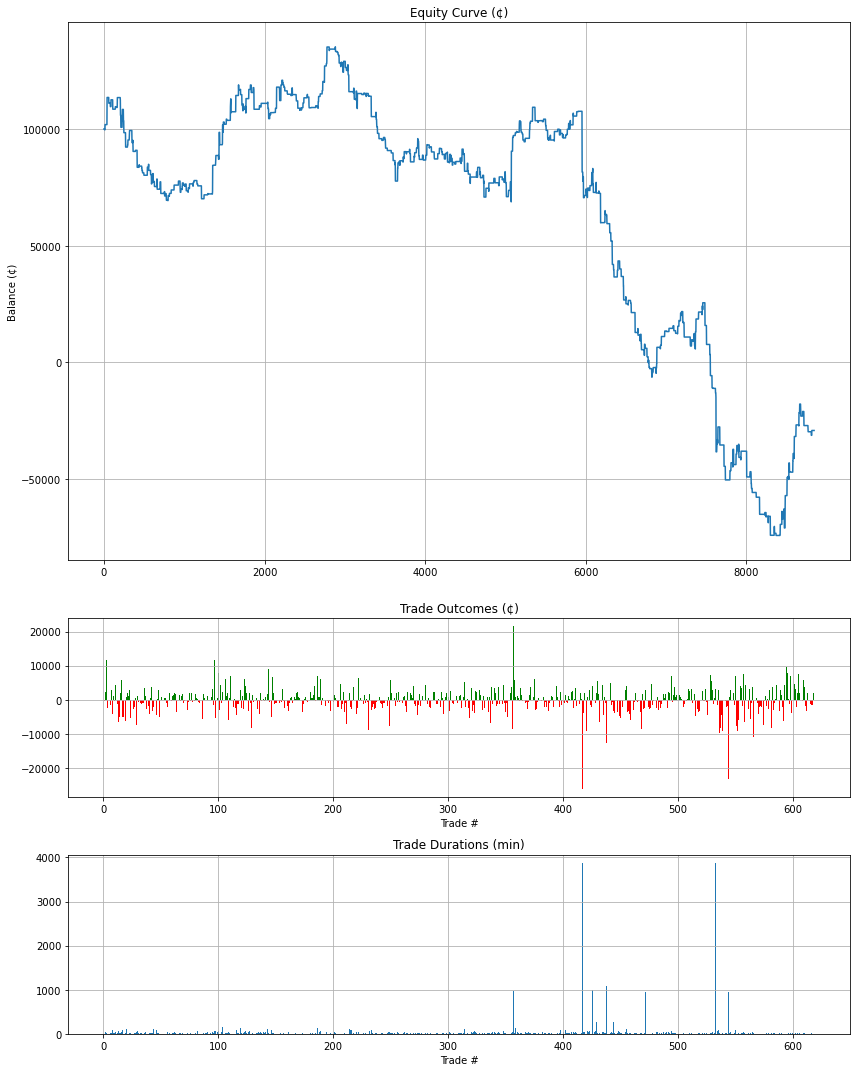

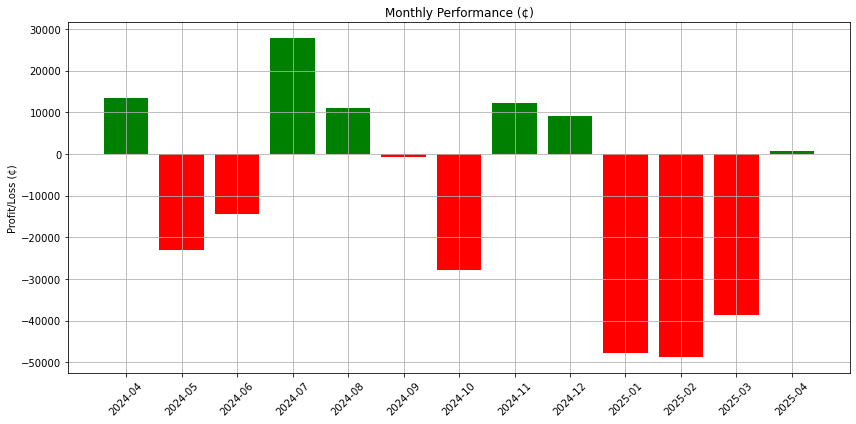


── Performance Summary ──
total_trades: 618
winning_trades: 286
losing_trades: 332
win_rate: 46.28%
profit_factor: 0.8409510903045597
total_profit_cents: -129099.99999976926
total_profit_usd: $-1291.00
total_return_percent: -129.10%
max_drawdown_percent: 154.79%
sharpe_ratio: -0.260348719170255
avg_win_cents: 2386.713286713663
avg_loss_cents: 2444.879518071918
largest_win_cents: 21675.000000000182
largest_loss_cents: -26024.999999999636
avg_trade_duration: 39.23139158576052
daily_results: {datetime.date(2024, 4, 30): 13475.000000001273, datetime.date(2024, 5, 2): -2474.9999999994543, datetime.date(2024, 5, 3): -1449.9999999993634, datetime.date(2024, 5, 6): 2925.000000000182, datetime.date(2024, 5, 7): -4024.999999999636, datetime.date(2024, 5, 8): 0, datetime.date(2024, 5, 9): 0, datetime.date(2024, 5, 10): 1075.0000000002728, datetime.date(2024, 5, 13): -324.9999999998181, datetime.date(2024, 5, 14): 4225.000000000364, datetime.date(2024, 5, 15): 0, datetime.date(2024, 5, 16): -7599

In [9]:

# ───────────────────────── example run ────────────────────────────
if __name__ == "__main__":
    bot = XAUUSDCentScalpingBot(
        initial_capital=100_000,
        risk_percent=1.0,
        take_profit_points=50,
        stop_loss_points=35,
        fast_ma_period=8,
        slow_ma_period=21,
        stoch_k_period=8,
        stoch_d_period=3,
        stoch_upper_level=75,
        stoch_lower_level=25,
        avg_spread_points=25,
        use_fixed_lot_size=True,
        fixed_lot_size=0.01,
        trailing_stop=True,
        trailing_distance=20,
        use_rsi_filter=True,
        trading_hours={"start": 8, "end": 16},
        max_daily_loss=-5.0,
    )

    # print("Running back-test on 1-minute timeframe …")
    # performance = bot.backtest("xau.csv")

        # Try the 5-minute timeframe instead
    print("Running backtest on 5-minute timeframe")
    performance = bot.backtest('xau.csv', use_timeframe='5T')
    if performance:
        bot.plot_results()
        bot.generate_trade_report("xauusd_trades_report.txt")
